<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "3F"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/3F/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


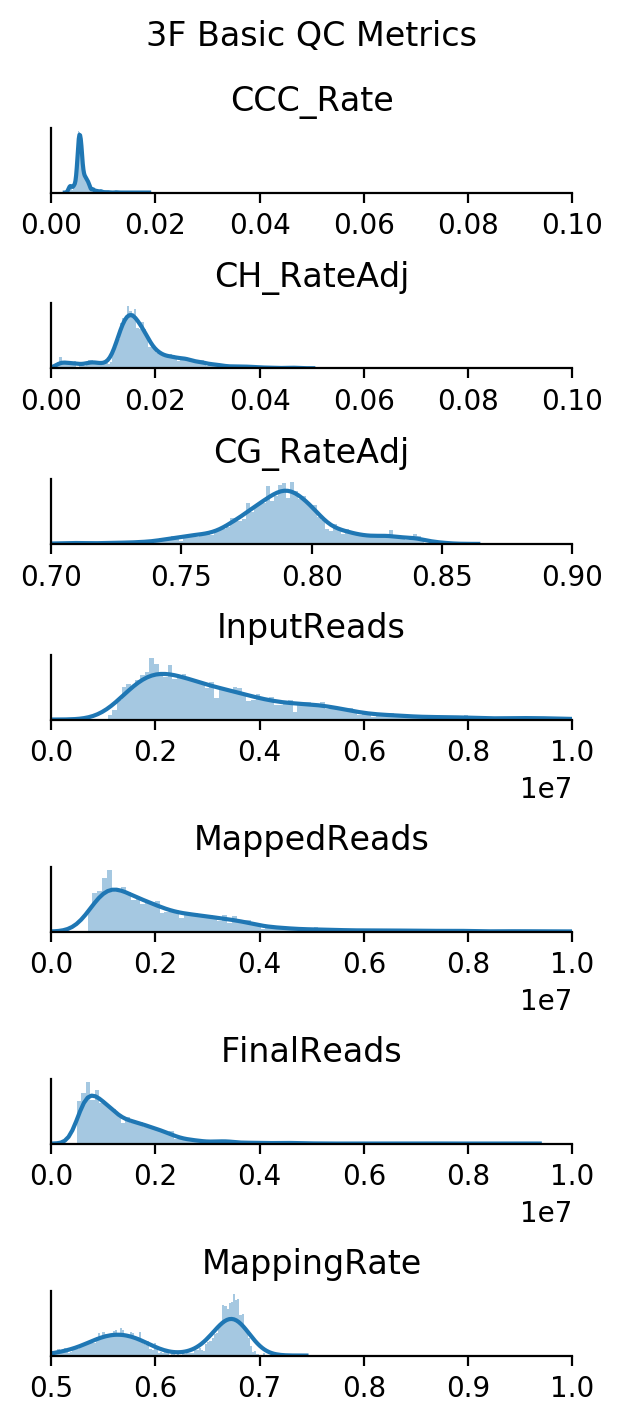

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

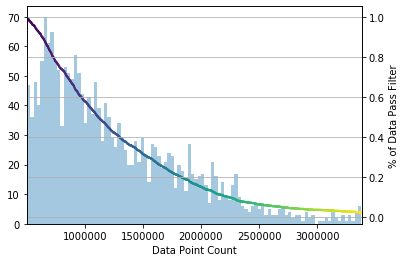

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2086/2086 (100.0%)
CG_RateAdj passed 2086/2086 (100.0%)
CH_RateAdj passed 2086/2086 (100.0%)
FinalReads passed 2086/2086 (100.0%)
MappingRate passed 2086/2086 (100.0%)
Overall passed 2086/2086 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180109 957
180405 1129


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 267 69.5%
ad002 287 74.7%
ad004 271 70.6%
ad006 208 54.2%
ad007 215 56.0%
ad008 281 73.2%
ad010 280 72.9%
ad012 277 72.1%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
3F_M_0,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.00352,0.74345,0.74254,0.00619,0.00268,2112242.0,5701272,3354313.0,3F,...,-3.325884,7.178353,15.103774,-31.979497,ASC str-hpf,9.948091,1.851987,-1.970187,-23.891070,True
3F_M_10,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.00373,0.75282,0.75189,0.00749,0.00377,1029642.0,2738028,1604013.0,3F,...,-5.005371,7.696533,4.263082,-29.664896,ASC str-hpf,7.221619,3.264130,6.206841,-11.464039,True
3F_M_100,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.00569,0.77591,0.77463,0.02224,0.01664,691324.0,1949012,1050335.0,3F,...,-3.976195,-17.845863,31.267591,-16.043350,MSN-D1 Ntn1,-13.285547,1.432165,26.794592,7.700932,True
3F_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.00578,0.78828,0.78705,0.02199,0.01630,933132.0,2968672,1722534.0,3F,...,7.658859,-9.563505,23.567632,42.304529,MSN-D2 Col14a1,0.846165,1.977796,11.020996,9.794150,True
3F_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.00699,0.78111,0.77957,0.03135,0.02453,1225252.0,3672260,2201178.0,3F,...,2.758455,5.428421,25.121897,-30.549951,OLF-Exc Cdh9,7.541663,-13.036026,-30.756167,-25.693932,True
3F_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.00393,0.75930,0.75835,0.00743,0.00351,1170268.0,3103414,1864328.0,3F,...,-4.917071,8.730023,4.274550,-26.503950,ASC str-hpf,8.215447,3.894939,8.232348,-14.420447,True
3F_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.00538,0.79879,0.79770,0.01973,0.01443,529434.0,1466392,826929.0,3F,...,1.917367,0.089946,-25.606517,39.628993,Foxp2 Dchs2,-0.126366,-5.907055,-5.933428,4.273153,True
3F_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.00524,0.76714,0.76591,0.01844,0.01327,689777.0,1970260,1098602.0,3F,...,3.754290,-2.896861,-5.919439,48.476965,Foxp2 Trpc7,-1.238268,2.958041,19.296017,-14.471625,True
3F_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.00796,0.82516,0.82376,0.04106,0.03337,894683.0,2472696,1388577.0,3F,...,-12.300880,0.427385,-16.003835,21.676615,PAL-Inh Meis2,9.310797,13.772326,27.529009,14.368234,True
3F_M_1006,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.00621,0.79173,0.79043,0.02596,0.01987,1010555.0,2995390,1762413.0,3F,...,-0.624665,-16.972858,21.817673,-11.684034,D1L-Fstl4 Grm3,13.396517,-7.317649,-27.546182,-9.956064,True
